## Imports

In [1]:
import pandas as pd
import gradio as gr
import nltk
import numpy as np
import matplotlib.pyplot as plt

from search import search_with_query
from machine_learning import MachineLearning

#import pca and preprocessing from sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing

## Files load

In [2]:
df_descripteur_porter = pd.read_csv('freq_poids_porter.csv')
df_descripteur_lancaster = pd.read_csv('freq_poids_lancaster.csv')

In [3]:
df_freqs_poids_porter = pd.read_csv('freq_poids_porter.csv')
df_freqs_poids_lancaster = pd.read_csv('freq_poids_lancaster.csv')

In [4]:
df_inverse = pd.read_csv('df_poids.csv').drop('Unnamed: 0', axis=1)

In [5]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

df_pca_dbscan = pd.read_csv('pca_df_dbscan.csv').drop(['label', 'Unnamed: 0'], axis=1)

In [6]:
queries_porter = pd.read_csv('queries_porter.csv')

In [7]:
ml = MachineLearning()

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '26

# Functions

## First tab functions

In [8]:
def search_document_descripteur(document, stemming_method):
        if stemming_method == 'Porter':
                new_df = df_descripteur_porter[df_descripteur_porter['Document']== document]
        elif stemming_method == 'Lancaster':
                new_df = df_descripteur_lancaster[df_descripteur_lancaster['Document']== document]
        new_df.drop(['Document'], axis=1, inplace=True)
        
        inverse = df_inverse.iloc[int(document)].to_frame()
        inverse = inverse[(inverse.T != 0.000000).all()]
        inverse = inverse.reset_index(level=0)
        inverse["Terme"] = inverse["index"]
        inverse["Poid"] = inverse[int(document)]
        inverse.drop([int(document)], axis=1, inplace=True)
        inverse.drop(['index'], axis=1, inplace=True)

        return [new_df, inverse]

In [9]:
def search_document_inverse(phrase, stemming_method):
        ExpReg = nltk. RegexpTokenizer('(?:[A-Za-z]\.)+|\d+(?:\.\d+)?%?|\w+(?:\-\w+)*')
        termes = ExpReg.tokenize(phrase)
        termes = [t.lower() for t in termes]
        MotsVides = nltk.corpus.stopwords.words('english')
        if stemming_method == 'Porter':
                Porter = nltk.PorterStemmer()
                TermesSansMotsVides_p = [Porter.stem(terme) for terme in termes if terme.lower() not in MotsVides]
        elif stemming_method == 'Lancaster':
                Lancaster = nltk.LancasterStemmer()
                TermesSansMotsVides_p = [Lancaster.stem(terme) for terme in termes if terme.lower() not in MotsVides]
        
        new_df = df_inverse[TermesSansMotsVides_p]
        new_df = new_df[(new_df.T != 0.000000).any()]
        new_df = new_df.reset_index(level=0)

        if stemming_method == 'Porter':
                desc_df = df_descripteur_porter.loc[df_descripteur_porter['Terme'].isin(TermesSansMotsVides_p) ]
        elif stemming_method == 'Lancaster':
                desc_df = df_descripteur_lancaster.loc[df_descripteur_lancaster['Terme'].isin(TermesSansMotsVides_p) ]

        #new_df.drop(['document'], axis=1, inplace=True)
        return new_df, desc_df

## Second tab function

In [10]:
def search_query(query):
        results = search_with_query(query)
        return pd.DataFrame(results)
        

In [11]:
# search_query("information AND classification OR NOT title AND computers")

## Third tab functions

In [12]:
df_pca_dbscan

,0,1
0,0.278896,0.347383
1,0.425996,0.616250
2,0.272333,0.244317
3,0.501636,0.798862
4,0.380549,0.672733
...,...,...
1455,0.333954,0.490487
1456,0.314208,0.704892
1457,0.188355,0.285995
1458,0.312763,0.235746


In [13]:
def run_dbscan_function(eps, min_samples):
        global X
        X = df_pca_dbscan.copy()
        dbscan = ml.DBSCAN(eps, min_samples, data=df_pca_dbscan.to_numpy())
        dbscan.fit()
        X['label'] = np.nan
        clusters = dbscan.get_clusters()
        noise = dbscan.get_noise()
        for cluster in range (len(clusters)):
                for element in clusters[cluster]:
                        #assign cluster number to each element
                        X.loc[element]['label'] = cluster
        for element in noise:
                #assign cluster number to each element
                X.loc[element]['label'] = -1
        fig,ax = plt.subplots((1,1))
        ax.scatter(X['0'],X['1'], c=X['label'], cmap='rainbow')
        ax.colorbar()
        res, plot_naive, plot_naive_scatter,confusion_matrix_naive, accuracy, precision, recall, f1 = run_naive_bayes()
        
        return fig, plot_naive, plot_naive_scatter, confusion_matrix_naive, accuracy, precision, recall, f1

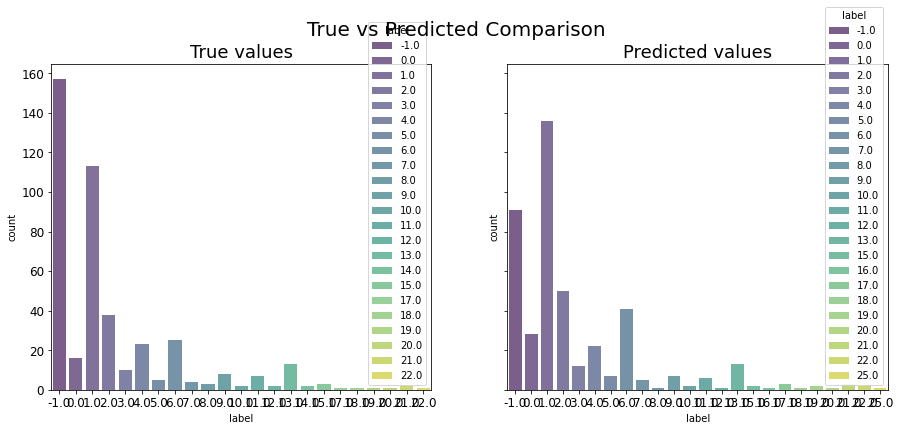

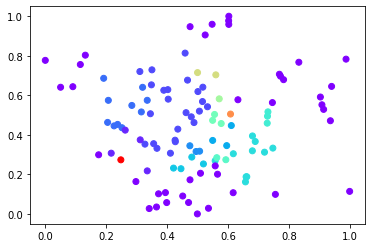

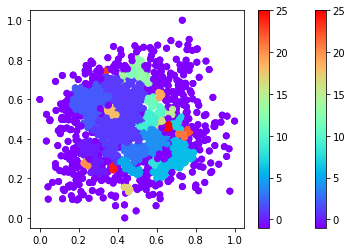

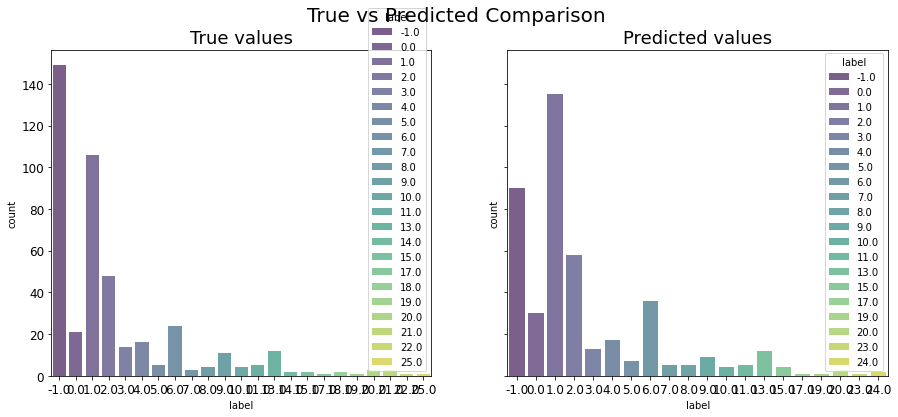

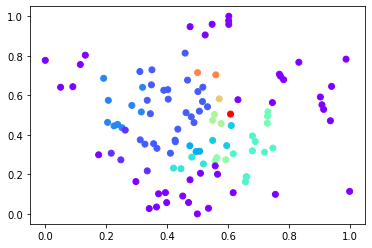

In [26]:
def run_naive_bayes():
        pca = PCA(n_components=2)
        pca.fit(queries_porter)
        x_pca = pca.transform(queries_porter)
        pca_df = pd.DataFrame(x_pca)
        x = pca_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        pca_df_normalized = pd.DataFrame(x_scaled)

        X_train, X_test, y_train, y_test = ml.train_test_split(X, test_size=0.3)
        bayes= ml.NaiveBayesClassifier()
        bayes.fit(X_train, y_train)
        predictions = bayes.predict(X_test.squeeze())
        while (len(np.unique(predictions)) < len(np.unique(X['label']))/2):
            X_train, X_test, y_train, y_test = ml.train_test_split(X, test_size=0.3)
            bayes= ml.NaiveBayesClassifier()
            bayes.fit(X_train, y_train)
            predictions = bayes.predict(X_test.squeeze())

        accuracy = bayes.accuracy(y_test, predictions)

        plot_naive = bayes.visualize(y_test, predictions, 'label')

        pca_df_normalized['label'] = bayes.predict(pca_df_normalized)
        fig2, ax = plt.subplots(1,1)
        ax.scatter(pca_df_normalized[0], pca_df_normalized[1], c=pca_df_normalized['label'], cmap='rainbow')
        
        predictions = pd.Series(predictions)
        y_test.reset_index(drop=True, inplace=True)
        confusion = bayes.confusion_matrix(y_test, predictions)
        precision = pd.DataFrame(bayes.precision(y_test, predictions), columns=['Precision'])
        recall = pd.DataFrame(bayes.recall(y_test, predictions), columns=['Recall'])
        f1 = pd.DataFrame(bayes.f1_score(y_test, predictions), columns=['F1 Score'])
        return bayes, plot_naive, fig2, confusion, accuracy, precision, recall, f1
        

numpy.ndarray

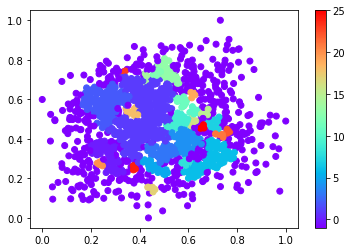

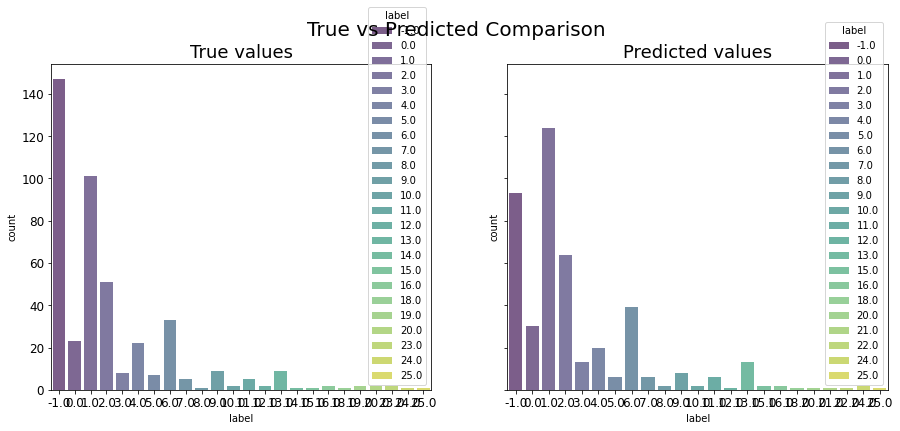

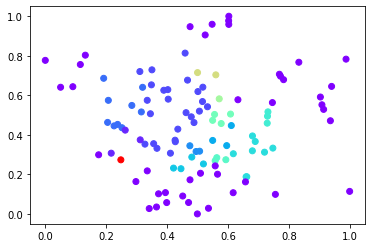

In [15]:
res = run_dbscan_function(0.022221,7)
type(res[5])

## Fourth Tab Function

## Main

In [16]:
queries = list(ml.qry_set.items())
queries[:] = [f"{elem[0]}: "+elem[1][:50] +"..." for elem in queries]


In [27]:
with gr.Blocks() as app:
        gr.Markdown("main app")
        with gr.Tab("Main Searches"):
                with gr.Row():
                        with gr.Column():
                                gr.Markdown("Search by Term")
                                search_input = gr.Textbox(label="Search for terms")
                                search_button = gr.Button(label="Search by Term")
                with gr.Row():
                        with gr.Column():
                                gr.Markdown("Search by Document")
                                search_document = gr.Number()
                        with gr.Column():
                                gr.Markdown("Stemming method")
                                stemming_method = gr.Radio(["Porter", "Lancaster"], label="Stemming")
                        search_document_button = gr.Button(label="Search by Document")
                with gr.Row():
                        with gr.Column():
                                gr.Markdown("Descripteur")
                                search_output_descripteur = gr.Numpy()
                        with gr.Column():
                                gr.Markdown("Inverse")
                                search_output_inverse = gr.Numpy()
        with gr.Tab("Boolean Search"):
                gr.Markdown("Boolean Search")
                search_boolean = gr.Textbox(label="Boolean search")
                search_boolean_button = gr.Button(label="Search")
                search_boolean_output = gr.Numpy()
        with gr.Tab("DBScan"):
                gr.Markdown("DBScan")
                with gr.Row():
                        with gr.Column():
                                plot_dbscan = gr.Plot()
                        with gr.Column():
                                eps = gr.Number()
                                min_samples = gr.Number()
                                run_dbscan = gr.Button(label="Run DBScan")
        with gr.Tab("Naive Bayes"):
                gr.Markdown("Naive Bayes")
                plot_naive = gr.Plot()
                with gr.Row():
                        with gr.Column():
                                plot_naive_scatter = gr.Plot()
                        with gr.Column():
                                accuracy = gr.Textbox(label = 'Accuracy')
                with gr.Row():
                        with gr.Column():
                                precision = gr.Numpy()
                        with gr.Column():
                                recall = gr.Numpy()
                        with gr.Column():
                                f1 = gr.Numpy()
                with gr.Row():
                        confusion_matrix_naive = gr.Numpy()
                
        with gr.Tab("Evaluation"):
                gr.Markdown("Evaluation")
                with gr.Row():
                        with gr.Column():
                                roc_curve = gr.Plot()
                        with gr.Column():
                                combo_queries = gr.Dropdown(queries)
                                with gr.Row():
                                        stemming_method_evaluation = gr.Radio(["Porter", "Lancaster"], label="Stemming")
                                with gr.Row():
                                        SRI = gr.Radio(["Cosinus", "Jaccard", "BM25", "Produit Scalaire", "Datamining"], label = "SRI")
                with gr.Row():
                        top10 = gr.Numpy()
                with gr.Row():
                        with gr.Column():
                                p5 = gr.Textbox(label = 'p@5')
                                p10 = gr.Textbox(label = 'p@10')
                        with gr.Column():
                                p5_inter = gr.Textbox(label = 'p@5 interpolée')
                                p10_inter = gr.Textbox(label = 'p@10_interpolée')


        search_button.click(search_document_inverse, inputs = [search_input, stemming_method], outputs = [search_output_inverse, search_output_descripteur])
        search_document_button.click(search_document_descripteur, inputs = [search_document, stemming_method], outputs = [search_output_descripteur, search_output_inverse])
        search_boolean_button.click(search_query, inputs = search_boolean, outputs = search_boolean_output)
        run_dbscan.click(run_dbscan_function, inputs = [eps, min_samples], outputs = [plot_dbscan, plot_naive, plot_naive_scatter, confusion_matrix_naive, accuracy, precision, recall, f1])
        #activate_naive.click(run_naive_bayes, outputs = [plot_naive, plot_naive_scatter, confusion_matrix_naive, accuracy, precision, recall, f1])
        

app.launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
